# Heat and Climate Patterns in Tamil Nadu: 2000–2023

## Data Modeling

<Figure size 1600x1600 with 0 Axes>

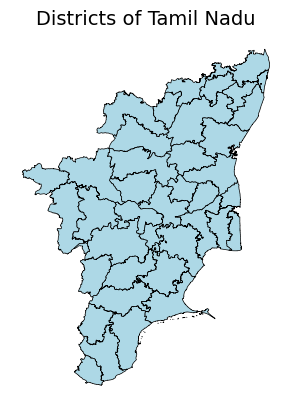

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
districts_gdf = gpd.read_file('/content/Districts.shp')

# Plot all districts
plt.figure(figsize=(16, 16))
gdf.plot(edgecolor='black', color='lightblue', linewidth=0.5)
plt.title("Districts of Tamil Nadu", fontsize=14)
plt.axis('off')
plt.show()

### District Centroid Calculation

In [8]:
# Step 1: Reproject to a projected CRS for India (UTM zone 43N – EPSG:32643)
districts_proj = districts_gdf.to_crs(epsg=32643)

# Step 2: Calculate centroids in projected CRS
districts_proj["centroid"] = districts_proj.geometry.centroid

# Step 3: Convert centroid back to lat/lon by reprojecting again
districts_proj["centroid_latlon"] = districts_proj["centroid"].to_crs(epsg=4326)

# Step 4: Extract latitude and longitude
districts_proj["lat"] = districts_proj["centroid_latlon"].y
districts_proj["lon"] = districts_proj["centroid_latlon"].x

# Step 5: Keep clean columns
location_grid = districts_proj[["district_n", "lat", "lon"]].rename(columns={"district_n": "district"})

# Save
location_grid.to_csv("tamil_nadu_district_centroids.csv", index=False)
location_grid.head()

,district,lat,lon
0,Tiruvallur,13.244421,79.933482
1,Chennai,13.061329,80.230349
2,Kancheepuram,12.833128,79.838146
3,Vellore,12.906982,78.960493
4,Dharmapuri,12.102811,78.191822


### Climate data API

In [9]:
import requests
import pandas as pd

def fetch_monthly_temperature_yearwise(lat, lon):
    """
    Fetch yearwise monthly average temperature (T2M) from NASA POWER API for a given lat/lon.
    Returns: DataFrame with columns: year, month, temperature_C
    """
    url = (
        f"https://power.larc.nasa.gov/api/temporal/monthly/point?"
        f"parameters=T2M&community=AG&longitude={lon}&latitude={lat}"
        f"&start=2000&end=2023&format=JSON"
    )

    response = requests.get(url)
    data = response.json()

    try:
        records = data["properties"]["parameter"]["T2M"]

        df = pd.DataFrame(list(records.items()), columns=['year_month', 'temperature_C'])
        df['year'] = df['year_month'].str[:4].astype(int)
        df['month'] = df['year_month'].str[4:].astype(int)
        df = df[['year', 'month', 'temperature_C']]
        # Remove invalid month 13
        df = df[df['month'].between(1, 12)]
        return df

    except KeyError:
        print(f"Data not found for lat={lat}, lon={lon}")
        return pd.DataFrame()

### Crafting Climate Data for Each District

In [10]:
def fetch_all_districts_temperature(centroid_csv):
    import pandas as pd
    from time import sleep

    df = pd.read_csv(centroid_csv)
    all_data = []

    for idx, row in df.iterrows():
        district = row['district']
        lat = row['lat']
        lon = row['lon']

        print(f"Fetching: {district} ({lat}, {lon})")
        try:
            temp_df = fetch_monthly_temperature_yearwise(lat, lon)
            temp_df['district'] = district
            all_data.append(temp_df)
            sleep(1)  # be polite to NASA API
        except Exception as e:
            print(f"Failed for {district}: {e}")

    final_df = pd.concat(all_data, ignore_index=True)
    return final_df

climate_df = fetch_all_districts_temperature("/content/tamil_nadu_district_centroids.csv")
climate_df.to_csv("tamil_nadu_climate_2000_2023.csv", index=False)

Fetching: Tiruvallur (13.24442085858594, 79.93348191514796)
Fetching: Chennai (13.06132949567314, 80.23034926967149)
Fetching: Kancheepuram (12.83312797825635, 79.83814587488055)
Fetching: Vellore (12.906982270505962, 78.96049347890387)
Fetching: Dharmapuri (12.10281086590618, 78.19182228020769)
Fetching: Thiruvannamalai (12.43242735189478, 79.1662000585565)
Fetching: Villupuram (12.118902585411696, 79.53174524709287)
Fetching: Salem (11.677480848829894, 78.22231988532336)
Fetching: Namakkal (11.31880893618749, 78.1357913199823)
Fetching: Erode (11.517851128531806, 77.41271336533457)
Fetching: The Nilgiris (11.457465317524388, 76.64048849793515)
Fetching: Coimbatore (10.854580603588383, 76.98503932327182)
Fetching: Dindigul (10.39178474221494, 77.82020680807746)
Fetching: Karur (10.84417839794835, 78.13449470583255)
Fetching: Tiruchirapalli (10.889949002669312, 78.5700280395804)
Fetching: Perambalur (11.275440618321554, 78.89085903581622)
Fetching: Ariyalur (11.162141405599128, 79.2426

### Urban ans Rural tags

In [11]:
# Example Urban vs Rural tags based on common knowledge
urban_districts = [
    'Chennai', 'Coimbatore', 'Madurai', 'Tiruchirappalli',
    'Salem', 'Tiruppur', 'Erode'
]

# Load the temperature data
import pandas as pd
df = pd.read_csv('/content/tamil_nadu_climate_2000_2023.csv')

# Tag each row as Urban or Rural
df['region_type'] = df['district'].apply(lambda x: 'Urban' if x in urban_districts else 'Rural')

# Preview
df

,year,month,temperature_C,district,region_type
0,2000,1,24.46,Tiruvallur,Rural
1,2000,2,26.55,Tiruvallur,Rural
2,2000,3,27.51,Tiruvallur,Rural
3,2000,4,30.88,Tiruvallur,Rural
4,2000,5,31.56,Tiruvallur,Rural
...,...,...,...,...,...
10939,2023,8,29.85,Mayiladuthurai,Rural
10940,2023,9,29.02,Mayiladuthurai,Rural
10941,2023,10,28.86,Mayiladuthurai,Rural
10942,2023,11,27.59,Mayiladuthurai,Rural


## Exploratory Data Analysis

### Data Summary

In [12]:
import pandas as pd

# 1. Check data and basic info
print("Region types:", df['region_type'].unique())
print("\nYear range:", df['year'].min(), "-", df['year'].max())

# 2. Hottest and coolest districts (overall)
temp_summary = (
    df.groupby('district')['temperature_C']
    .mean()
    .sort_values(ascending=False)
)

hottest = temp_summary.head(5)
coolest = temp_summary.tail(5)

print("\nHottest Districts (avg temp):")
print(hottest)

print("\nCoolest Districts (avg temp):")
print(coolest.sort_values(ascending=True))

# 3. Year with highest statewide average
yearly_avg = (
    df.groupby('year')['temperature_C']
    .mean()
    .sort_values(ascending=False)
)

print("\nHottest Year Overall:")
print(yearly_avg.head(1))

# 4. Compare urban vs rural average temperature
urban_rural_avg = (
    df.groupby('region_type')['temperature_C']
    .mean()
)

print("\nUrban vs Rural Avg Temp:")
print(urban_rural_avg)

# 5. Most extreme months (any region, any year)
extreme_months = df.sort_values('temperature_C', ascending=False).head(5)
print("\nTop 5 Extreme Monthly Temperatures:")
print(extreme_months[['district', 'region_type', 'year', 'month', 'temperature_C']])

Region types: ['Rural' 'Urban']

Year range: 2000 - 2023

Hottest Districts (avg temp):
district
Thanjavur         28.288681
Tiruvarur         28.288681
Nagapattinam      28.266007
Mayiladuthurai    28.258299
Ramanathapuram    28.205660
Name: temperature_C, dtype: float64

Coolest Districts (avg temp):
district
The Nilgiris    23.468056
Theni           23.714688
Coimbatore      24.539861
Krishnagiri     24.787326
Vellore         25.306979
Name: temperature_C, dtype: float64

Hottest Year Overall:
year
2019    27.645
Name: temperature_C, dtype: float64

Urban vs Rural Avg Temp:
region_type
Rural    26.994725
Urban    26.686453
Name: temperature_C, dtype: float64

Top 5 Extreme Monthly Temperatures:
           district region_type  year  month  temperature_C
10408       Ranipet       Rural  2003      5          33.69
6280    Pudukkottai       Rural  2019      5          33.47
3939          Karur       Rural  2016      4          33.27
9123       Tiruppur       Urban  2016      4         

### Significance Test

#### T-Test: Urban vs Rural Temperatures (Are they significantly different?)

In [13]:
from scipy.stats import ttest_ind

# Separate data
urban_temps = df[df['region_type'] == 'Urban']['temperature_C']
rural_temps = df[df['region_type'] == 'Rural']['temperature_C']

# Perform independent t-test
t_stat, p_val = ttest_ind(urban_temps, rural_temps, equal_var=False)  # Welch's t-test

print("T-Test: Urban vs Rural Temperatures")
print(f"\nT-statistic = {t_stat:.4f}")
print(f"\nP-value = {p_val:.4e}")

if p_val < 0.05:
    print("\nStatistically significant difference (p < 0.05)")
else:
    print("\nNo significant difference (p ≥ 0.05)")

T-Test: Urban vs Rural Temperatures

T-statistic = -4.4849

P-value = 7.6249e-06

Statistically significant difference (p < 0.05)


In [34]:
pip install pymannkendall

In [38]:
import pymannkendall as mk
import pandas as pd

# Group by year and district
district_yearly = df.groupby(['year', 'district'])['temperature_C'].mean().reset_index()

# Unique districts
districts = district_yearly['district'].unique()

results = []

for dist in districts:
    temp_series = district_yearly[district_yearly['district'] == dist].sort_values('year')['temperature_C']
    years = district_yearly[district_yearly['district'] == dist].sort_values('year')['year'].values

    # Mann-Kendall test
    test_result = mk.original_test(temp_series)

    results.append({
        'district': dist,
        'slope': test_result.slope,
        'trend': test_result.trend,
        'p': test_result.p,
        'h': test_result.h
    })

mk_df = pd.DataFrame(results)

# Only districts with statistically significant increasing trends
warming_districts = mk_df[(mk_df['trend'] == 'increasing') & (mk_df['p'] < 0.05)]

# Sort by slope (fastest warming first)
warming_districts = warming_districts.sort_values(by='slope', ascending=False)
warming_districts

,district,slope,trend,p,h
28,Thoothukudi,0.060011,increasing,0.000426,True
23,Tenkasi,0.051244,increasing,0.001375,True
37,Virudhunagar,0.047119,increasing,0.010623,True
10,Kanniyakumari,0.045989,increasing,0.000565,True
30,Tirunelveli,0.045989,increasing,0.000565,True
19,Ramanathapuram,0.044981,increasing,0.003160,True
15,Nagapattinam,0.015024,increasing,0.010623,True


### Plots

In [14]:
import os

# Create a folder to store plots
plot_dir = "project_figures"
os.makedirs(plot_dir, exist_ok=True)

# Helper function to save plots
def save_plot(name, dpi=300):
    plt.savefig(os.path.join(plot_dir, f"{name}.png"), dpi=dpi, bbox_inches='tight')
    plt.close()

#### State Wise Analysis

##### Seasonal Temperature Map of Tamil Nadu

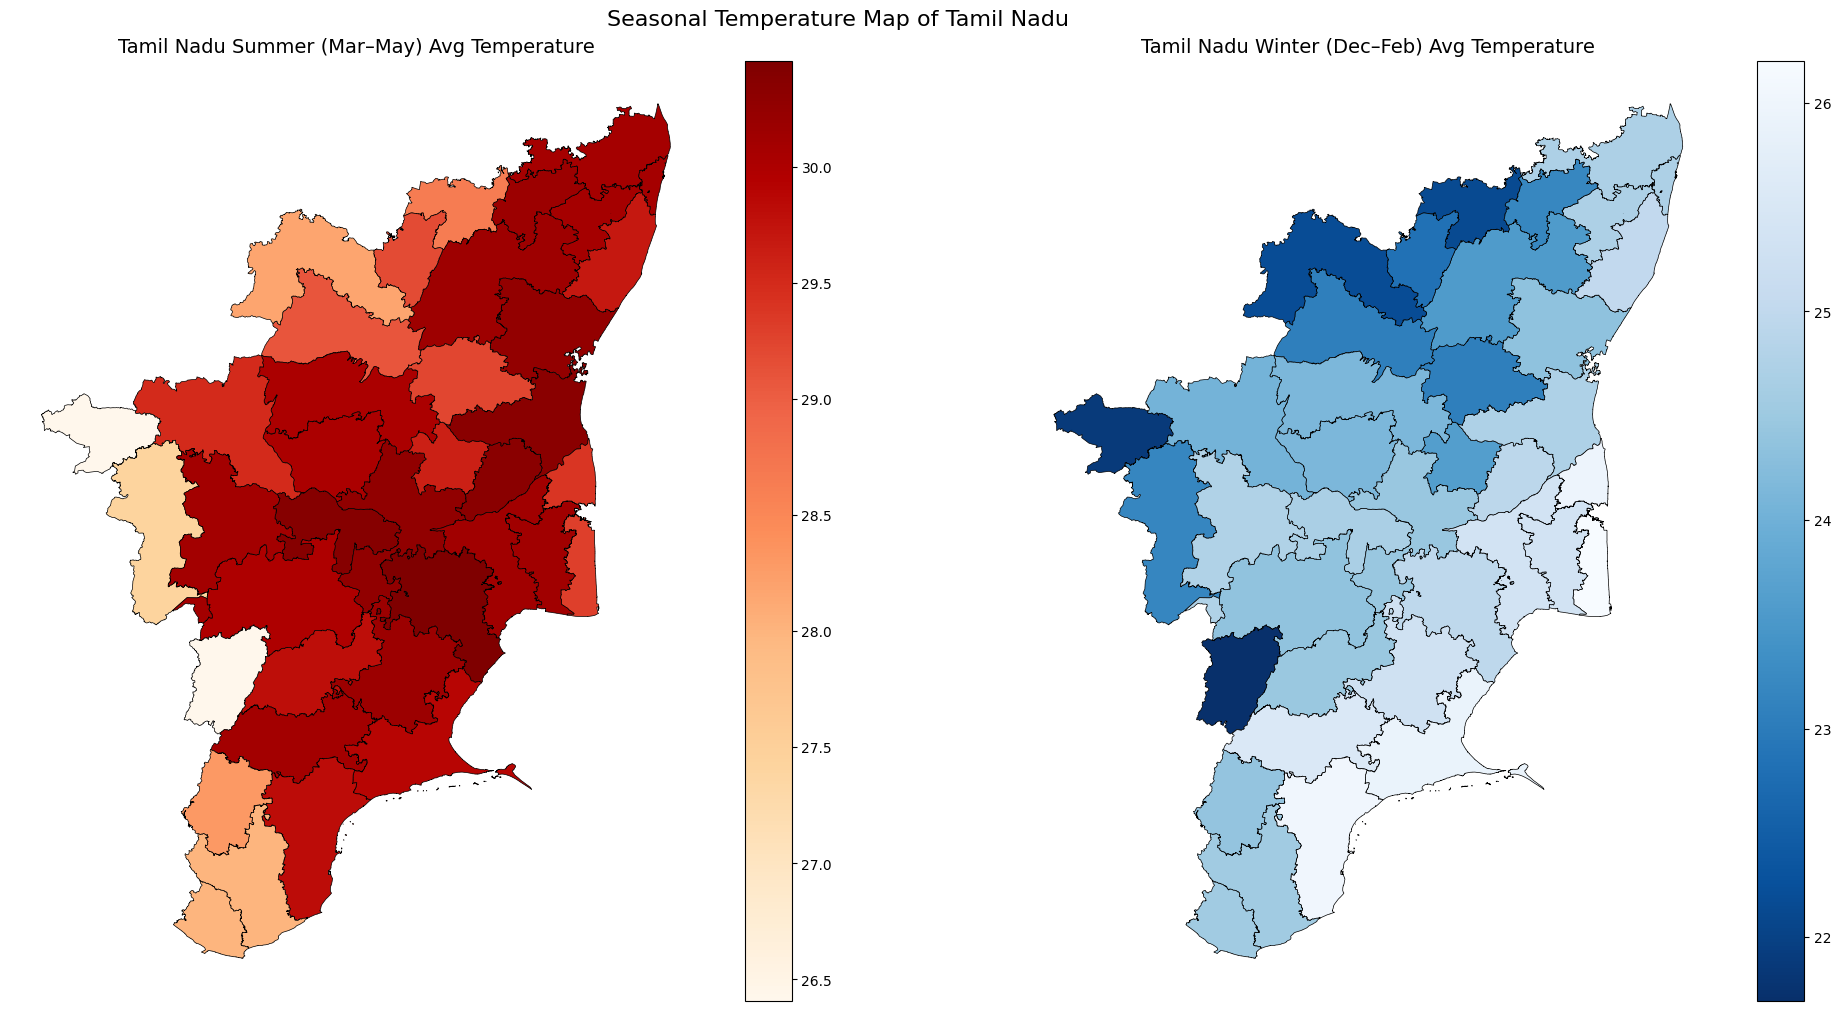

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Define seasons and corresponding colormaps
season_settings = {
    "Summer (Mar–May)": {"months": [3, 4, 5], "cmap": "OrRd"},
    "Winter (Dec–Feb)": {"months": [12, 1, 2], "cmap": "Blues_r"}  # Reverse for colder = darker
}

# Set up figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)

# Plot each season
for ax, (season_name, settings) in zip(axes, season_settings.items()):
    months = settings["months"]
    cmap = settings["cmap"]

    # Filter and group
    season_df = df[df['month'].isin(months)]
    season_avg = (
        season_df.groupby('district')['temperature_C']
        .mean()
        .reset_index()
        .rename(columns={'district': 'district_n'})
    )

    # Merge with shapefile
    merged_gdf = districts_gdf.merge(season_avg, on='district_n', how='left')

    # Plot
    merged_gdf.plot(
        column='temperature_C',
        cmap=cmap,
        legend=True,
        edgecolor='black',
        linewidth=0.5,
        ax=ax
    )

    # Aesthetics
    ax.set_title(f"Tamil Nadu {season_name} Avg Temperature", fontsize=14)
    ax.axis('off')

plt.suptitle("Seasonal Temperature Map of Tamil Nadu", fontsize=16)
plt.show()
save_plot("Seasonal Temperature Map of Tamil Nadu")

##### Heat Wave Frequency of Tamil Nadu

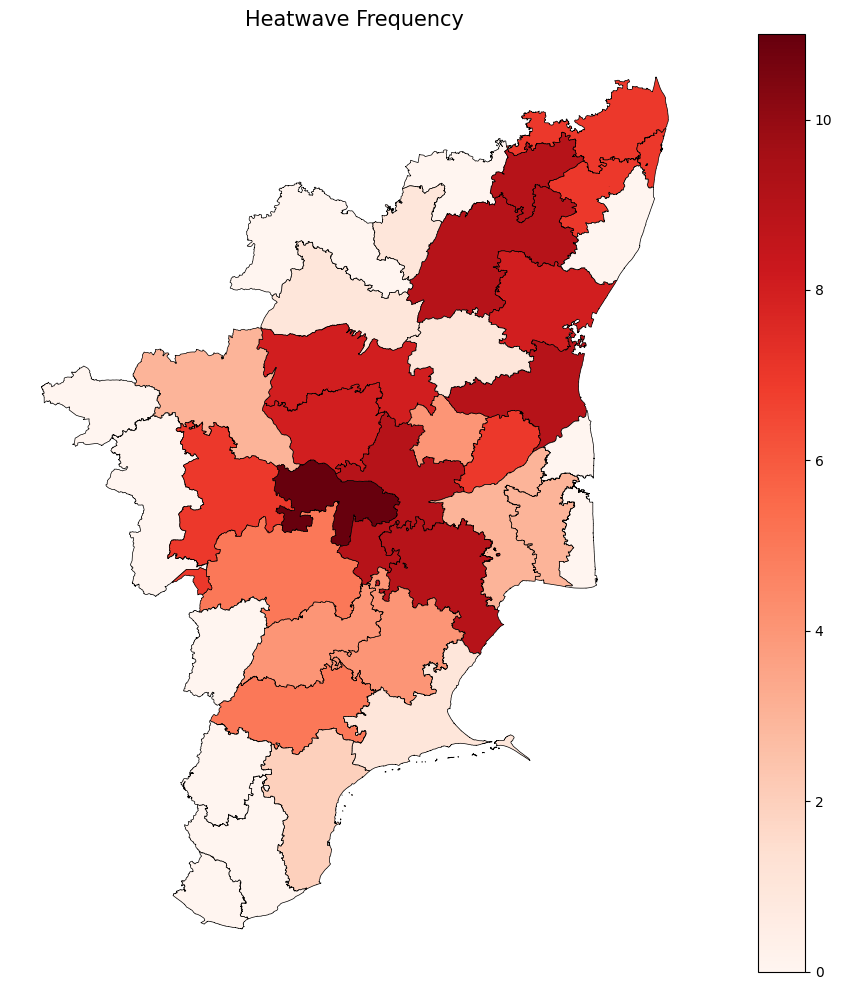

In [25]:
# Define heatwave threshold
threshold = 32.0
# Filter data for hot months only
heatwave_df = df[df['temperature_C'] > threshold]

# Count occurrences by district
heatwave_counts = heatwave_df.groupby('district').size().reset_index(name='heatwave_months')

# Rename column for merging
heatwave_counts = heatwave_counts.rename(columns={'district': 'district_n'})

# Merge with district boundaries
heatwave_map = districts_gdf.merge(heatwave_counts, on='district_n', how='left')

# Fill districts with zero heatwave months
heatwave_map['heatwave_months'] = heatwave_map['heatwave_months'].fillna(0)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))
heatwave_map.plot(
    column='heatwave_months',
    cmap='Reds',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    ax=ax
)

ax.set_title('Heatwave Frequency', fontsize=15)
ax.axis('off')
plt.tight_layout()
plt.show()
save_plot('Heatwave Frequency')

#### District Wise Analysis

##### District-wise Average Temperature

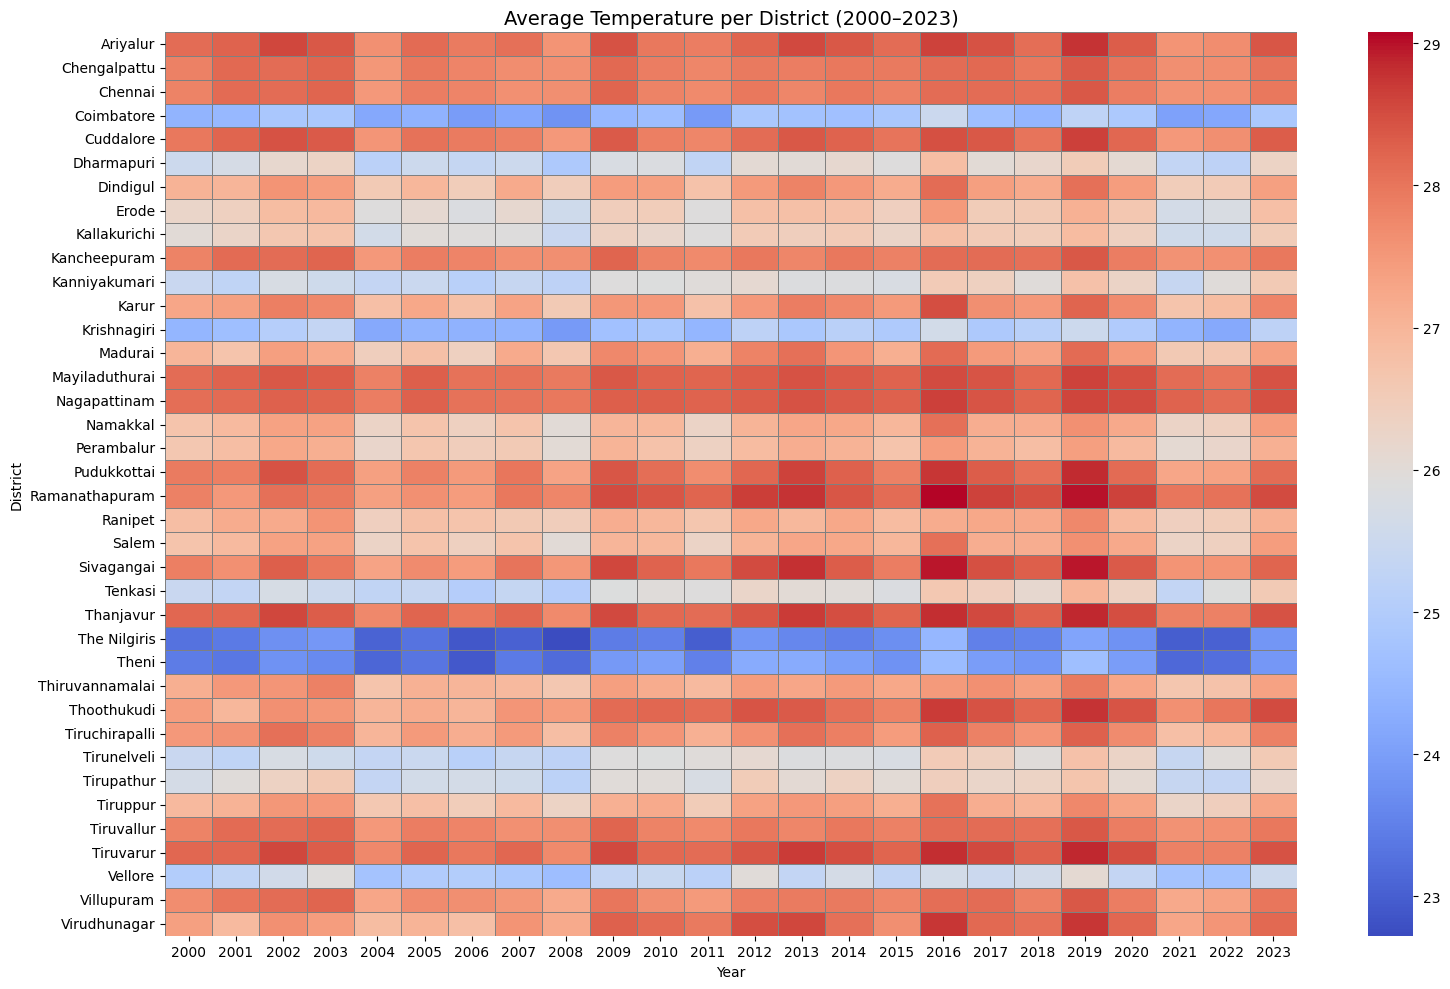

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Group and pivot
heatmap_data = (
    df.groupby(['district', 'year'])['temperature_C']
    .mean()
    .reset_index()
    .pivot(index='district', columns='year', values='temperature_C')
)

# Step 2: Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, linewidths=0.5, linecolor='gray')
plt.title('Average Temperature per District (2000–2023)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('District')
plt.tight_layout()
plt.show()
save_plot('Average Temperature per District (2000–2023)')

##### Top 5 Hottest Urban Districts – Temperature Trend (2000–2023)

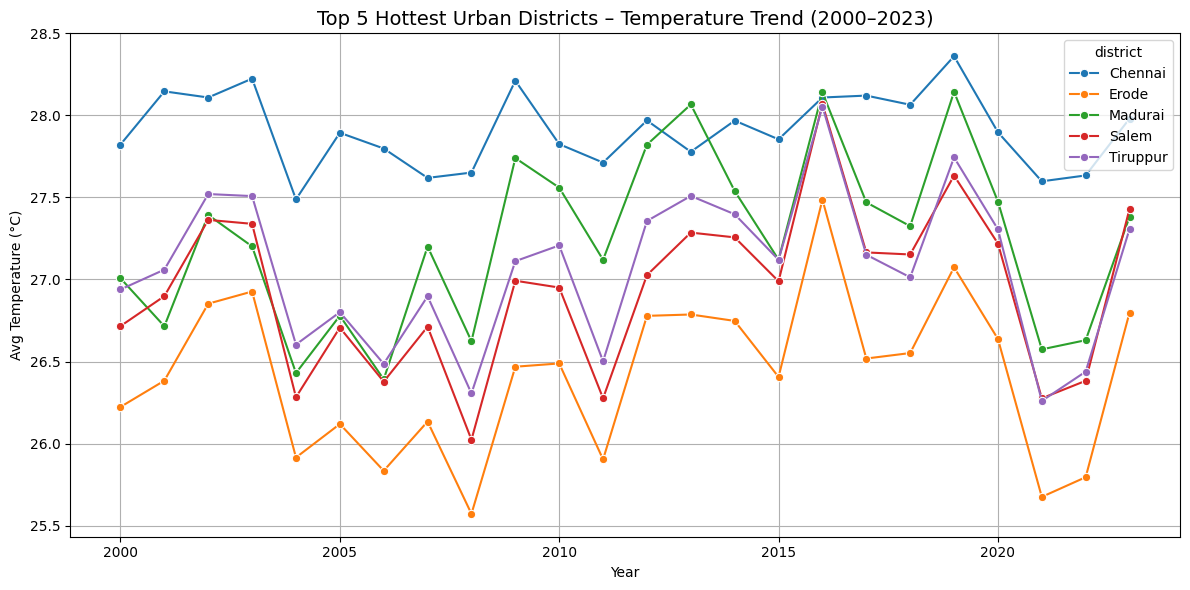

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filter only Urban regions
urban_df = df[df['region_type'] == 'Urban']

# 2. Calculate average temperature for each district across all years
avg_temp_by_district = (
    urban_df.groupby('district')['temperature_C']
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# 3. Filter data for top 5 hottest districts
top5_df = urban_df[urban_df['district'].isin(avg_temp_by_district)]

# 4. Group by year and district
trend_df = (
    top5_df.groupby(['year', 'district'])['temperature_C']
    .mean()
    .reset_index()
)

# 5. Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_df, x='year', y='temperature_C', hue='district', marker='o')
plt.title("Top 5 Hottest Urban Districts – Temperature Trend (2000–2023)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Avg Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()
save_plot("Top 5 Hottest Urban Districts – Temperature Trend (2000–2023)")

#### Urban vs Rural Temperatures

##### Heatmap for temperature difference between urban and rural

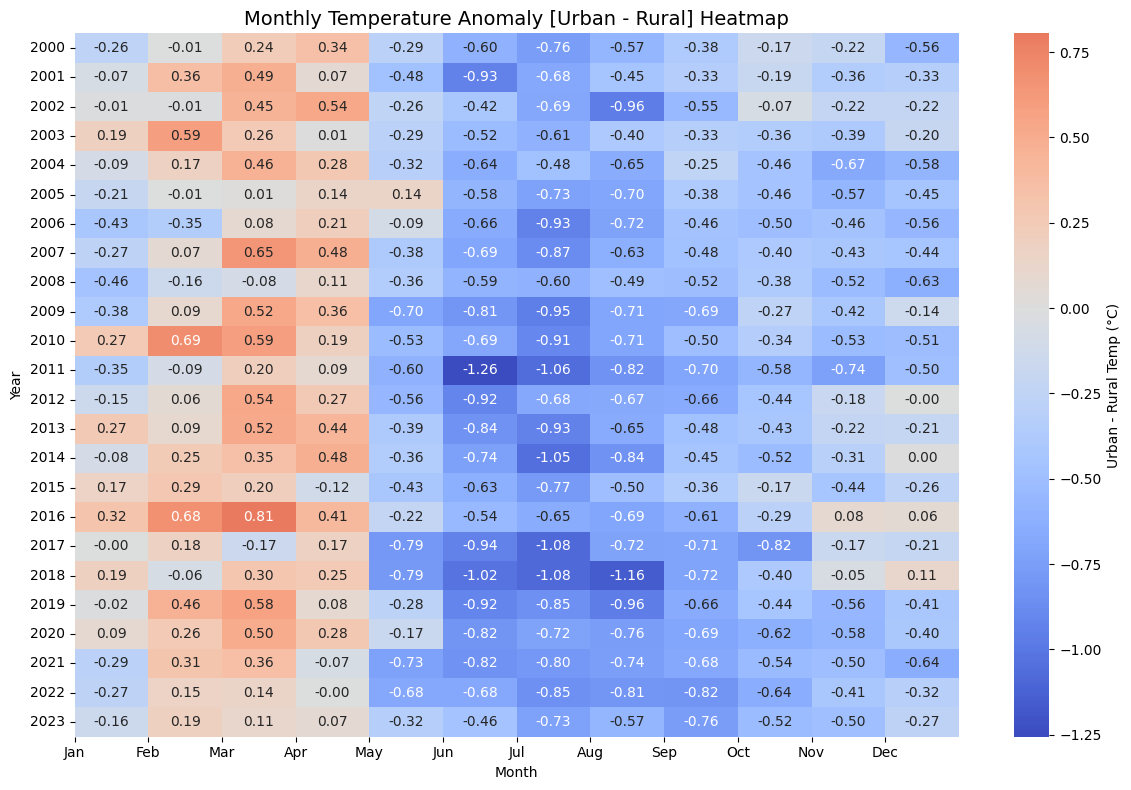

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Group and get mean temperature
monthly_grouped = (
    df.groupby(['year', 'month', 'region_type'])['temperature_C']
    .mean()
    .reset_index()
)

# Step 2: Separate Urban and Rural
urban = monthly_grouped[monthly_grouped['region_type'] == 'Urban'][['year', 'month', 'temperature_C']].rename(columns={'temperature_C': 'urban_temp'})
rural = monthly_grouped[monthly_grouped['region_type'] == 'Rural'][['year', 'month', 'temperature_C']].rename(columns={'temperature_C': 'rural_temp'})

# Step 3: Merge on year and month
uhi_df = pd.merge(urban, rural, on=['year', 'month'], how='inner')

# Step 4: Calculate anomaly
uhi_df['uhi_anomaly'] = uhi_df['urban_temp'] - uhi_df['rural_temp']

# Step 5: Pivot for heatmap
heatmap_df = uhi_df.pivot(index='year', columns='month', values='uhi_anomaly')

# Step 6: Plot
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, cmap='coolwarm', center=0, annot=True, fmt=".2f", cbar_kws={'label': 'Urban - Rural Temp (°C)'})
plt.title("Monthly Temperature Anomaly [Urban - Rural] Heatmap", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Year")
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.tight_layout()
plt.show()
save_plot("Monthly Temperature Anomaly [Urban - Rural] Heatmap")

##### Trendline of Temperature difference between Urban and Rural area

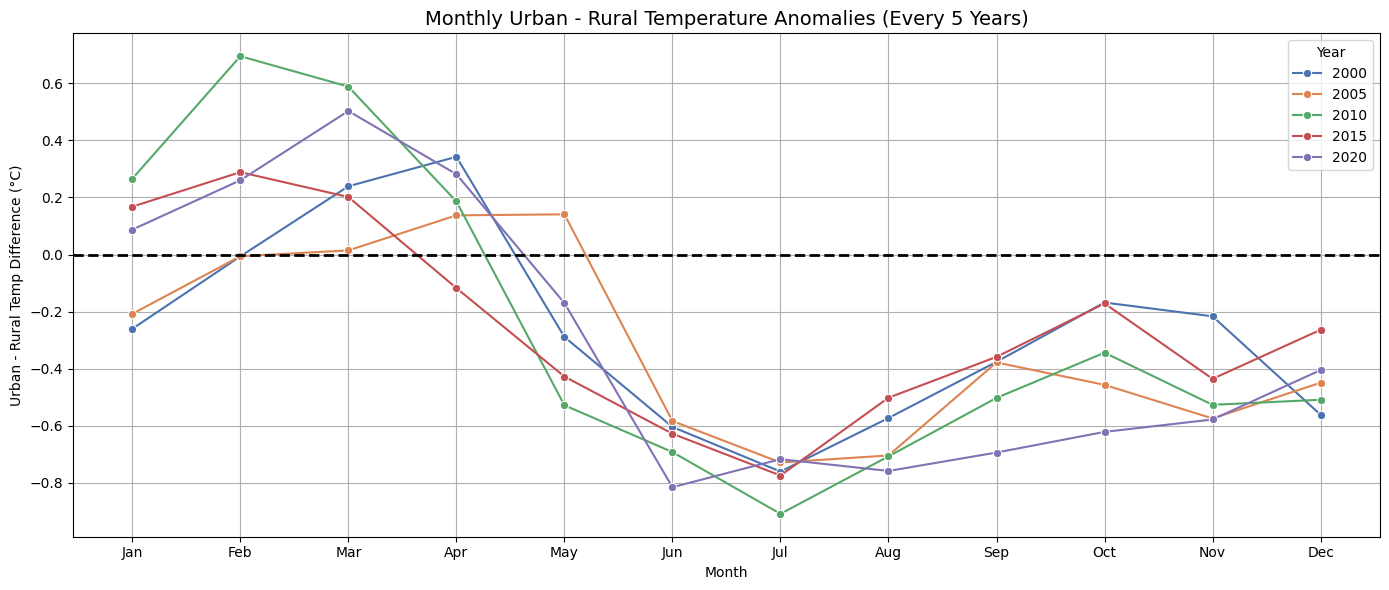

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Group by year, month, region_type
monthly_avg = (
    df.groupby(['year', 'month', 'region_type'])['temperature_C']
    .mean()
    .reset_index()
)

# Step 2: Pivot to get Urban and Rural columns
pivot_df = monthly_avg.pivot_table(
    index=['year', 'month'],
    columns='region_type',
    values='temperature_C'
).reset_index()

# Step 3: Compute Urban - Rural anomaly
pivot_df['urban_rural_anomaly'] = pivot_df['Urban'] - pivot_df['Rural']

# Step 4: Filter for every 5 years
filtered_df = pivot_df[pivot_df['year'].isin([2000, 2005, 2010, 2015, 2020])]

# Step 5: Plot
plt.figure(figsize=(14, 6))

sns.lineplot(
    data=filtered_df,
    x='month',
    y='urban_rural_anomaly',
    hue='year',
    palette='deep',
    marker='o'
)

# Bold baseline at y=0
plt.axhline(0, color='black', linewidth=2, linestyle='--')

plt.title("Monthly Urban - Rural Temperature Anomalies (Every 5 Years)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Urban - Rural Temp Difference (°C)")
plt.xticks(
    range(1, 13),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)
plt.grid(True)
plt.legend(title='Year')
plt.tight_layout()
plt.show()
save_plot("Monthly Urban - Rural Temperature Anomalies (Every 5 Years)")

##### Temperature Anomaly between Urban and Rural area (March vs July)

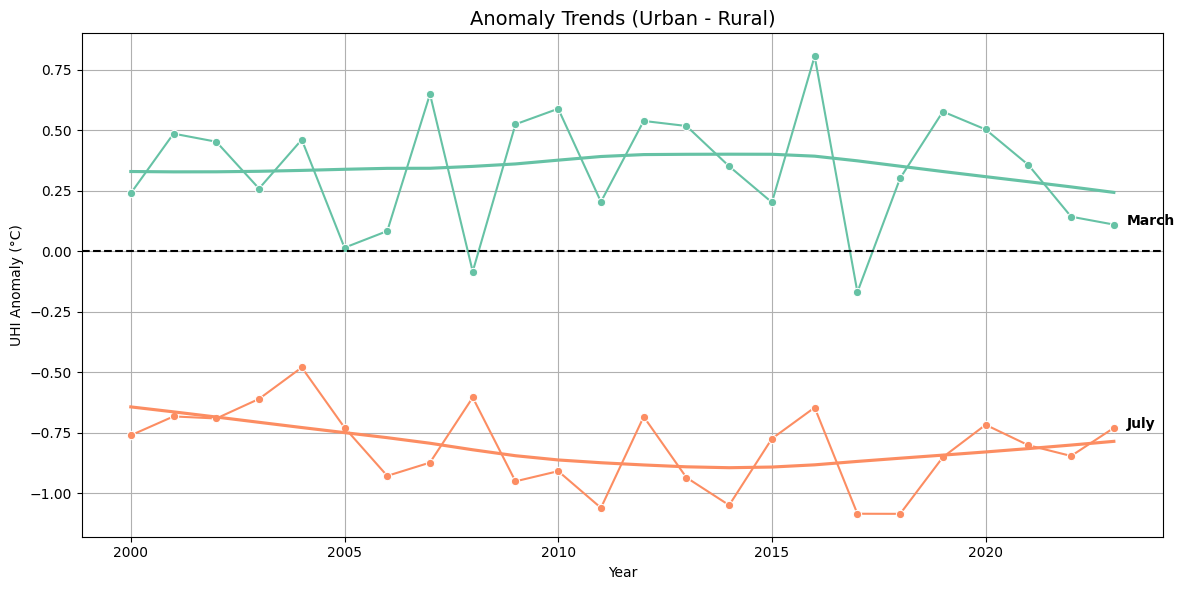

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Group by year, month, region_type
monthly_avg = (
    df.groupby(['year', 'month', 'region_type'])['temperature_C']
    .mean()
    .reset_index()
)

# Step 2: Pivot Urban and Rural
pivot = monthly_avg.pivot_table(
    index=['year', 'month'],
    columns='region_type',
    values='temperature_C'
).reset_index()

# Step 3: UHI anomaly calculation
pivot['uhi_anomaly'] = pivot['Urban'] - pivot['Rural']

# Step 4: Filter March and July
selected_months = [3, 7]
subset = pivot[pivot['month'].isin(selected_months)].copy()  # .copy() to avoid warning
subset.loc[:, 'month_name'] = subset['month'].map({3: 'March', 7: 'July'})

# Step 5: Plotting
plt.figure(figsize=(12, 6))
palette = {'March': '#66c2a5', 'July': '#fc8d62'}

# Plot actual values and smoothed trendlines
for month in subset['month_name'].unique():
    data = subset[subset['month_name'] == month]
    sns.lineplot(data=data, x='year', y='uhi_anomaly', color=palette[month], marker='o')
    sns.regplot(data=data, x='year', y='uhi_anomaly', scatter=False, color=palette[month], lowess=True)

    # Label the last point
    last_row = data[data['year'] == data['year'].max()]
    if not last_row.empty:
        x = last_row['year'].values[0]
        y = last_row['uhi_anomaly'].values[0]
        plt.text(x + 0.3, y, month, fontsize=10, weight='bold')

# Baseline at 0
plt.axhline(0, color='black', linewidth=1.5, linestyle='--')

# Titles and labels
plt.title('Anomaly Trends (Urban - Rural)', fontsize=14)
plt.ylabel('UHI Anomaly (°C)')
plt.xlabel('Year')
plt.grid(True)
plt.tight_layout()
plt.show()
save_plot('Anomaly Trends (Urban - Rural)')

##### Monthly Seasonal Temperature Pattern (Urban vs Rural)

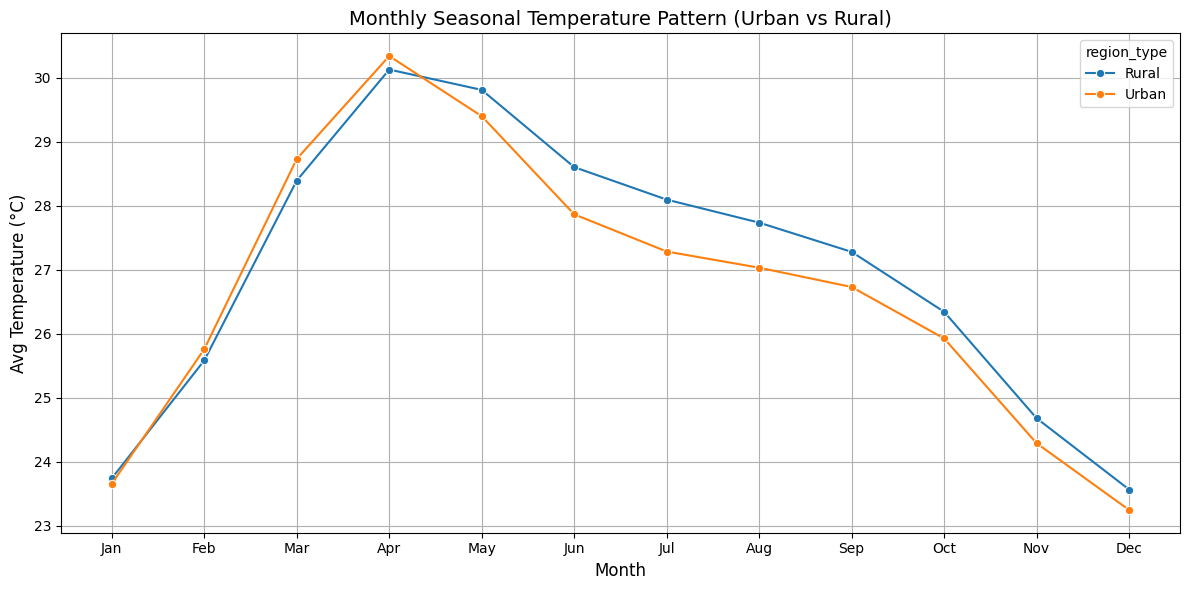

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by month and region type
monthly_avg = df.groupby(['month', 'region_type'])['temperature_C'].mean().reset_index()

# Month ordering (optional for better x-axis readability)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg, x='month', y='temperature_C', hue='region_type', marker='o')

plt.title('Monthly Seasonal Temperature Pattern (Urban vs Rural)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Avg Temperature (°C)', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=month_labels)
plt.grid(True)
plt.tight_layout()
plt.show()
save_plot('Monthly Seasonal Temperature Pattern (Urban vs Rural)')

##### Urban vs Rural Warming Trend (2000–2023)

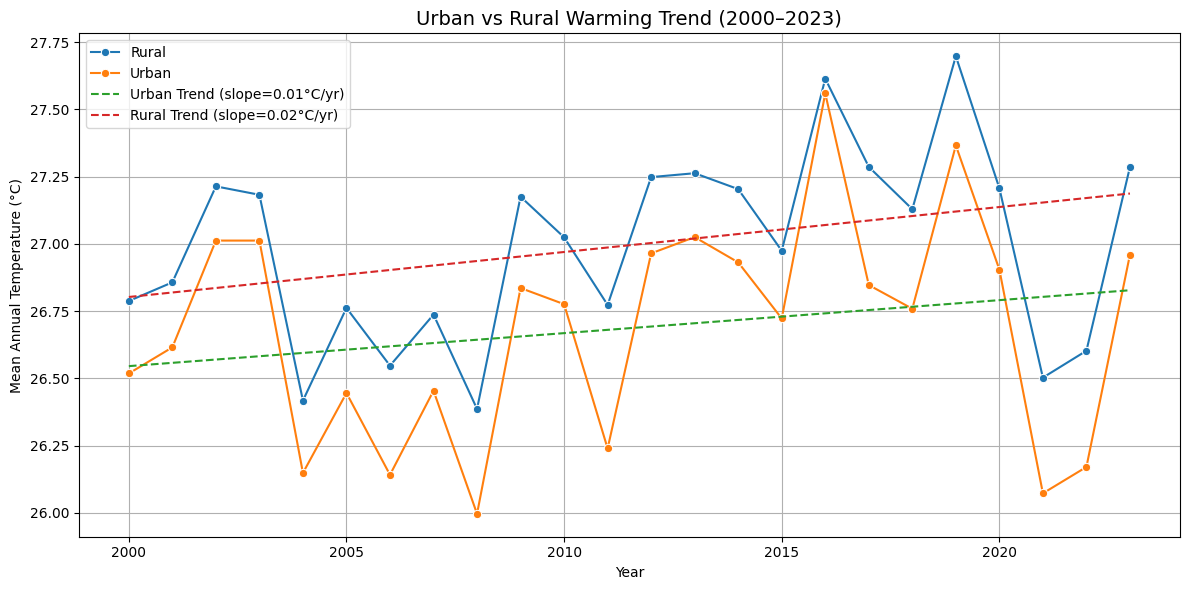

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Step 1: Group by year and region_type to compute mean annual temperature
trend_df = (
    df.groupby(['year', 'region_type'])['temperature_C']
    .mean()
    .reset_index()
)

# Step 2: Plot trendlines
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_df, x='year', y='temperature_C', hue='region_type', marker='o')

# Step 3: Linear regression fits
for region in ['Urban', 'Rural']:
    sub = trend_df[trend_df['region_type'] == region]
    slope, intercept, r_value, p_value, std_err = linregress(sub['year'], sub['temperature_C'])
    plt.plot(
        sub['year'],
        intercept + slope * sub['year'],
        linestyle='--',
        label=f'{region} Trend (slope={slope:.2f}°C/yr)'
    )

# Final touches
plt.title("Urban vs Rural Warming Trend (2000–2023)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Mean Annual Temperature (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
save_plot("Urban vs Rural Warming Trend (2000–2023)")